### AB42: DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
### AB40: DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV

In [1]:
# !pip install MDAnalysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

In [ ]:
# 1. Confirmed that at pH 8.5, the NE1 nitrogen in histidine is protonated based on experimental data. 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4082993/

# 2. Changed aminoacids.c.tdb OH to OH1. Potential typo in force field files.

In [ ]:
# using hydrogen mass repartitioning for longer timesteps
gmx_mpi pdb2gmx -f ab40.pdb -o template.gro -ignh -heavyh -water tip3p

gmx_mpi pdb2gmx -f ab40.pdb -o template.gro -water tip3p -ignh

gmx_mpi editconf -f ../template.gro -o template_newbox.gro -c -d 2 -bt dodecahedron

gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top


In [ ]:
# following Alice's instructions to collapse the protein
# 1 – energy minimisation

# 2 – position restraints

# 3 – Berendsen, using the .mdp file I attached below at 310K (this won’t collapse the structure, it’s just a step before to equilibrate)

# 4 – NVT 600K to get the collapsed structure

In [ ]:
# Step 1
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c template_solv.gro -p ../topol.top -o em_input.tpr -maxwarn 2

# Got the following warning
# WARNING 1 [file ffnonbonded.itp, line 68]:
#   Atomtype OT was defined previously (e.g. in the forcefield files), and
#   has now been defined again. This could happen e.g. if you would use a
#   self-contained molecule .itp file that duplicates or replaces the
#   contents of the standard force-field files. You should check the contents
#   of your files and remove such repetition. If you know you should override
#   the previous definition, then you could choose to suppress this warningb
#   with -maxwarn.

gerun gmx_mpi mdrun -s em -v -maxh 10 &> em_terminal.log

In [ ]:
# Step 2

gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em_output.gro -r em_output.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr_terminal.log

In [ ]:
# Step 3

gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

In [ ]:
# Step 4

gmx_mpi grompp -f ../mdp_files/4-nvt-600.mdp -c 3-berendsen.gro -r 3-berendsen.gro -p ../topol.top -o 4-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal.log

# restarting step 4
gerun gmx_mpi mdrun -cpi 4-nvt-600 -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal-r2.log

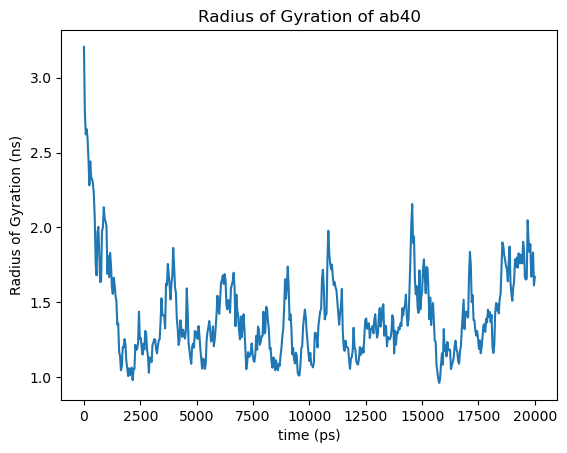

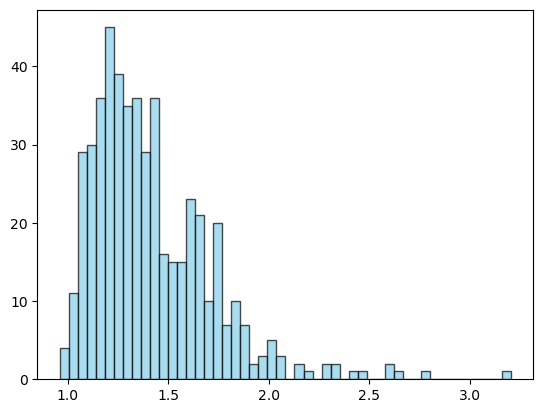

(array([1], dtype=int64),)
1.96781


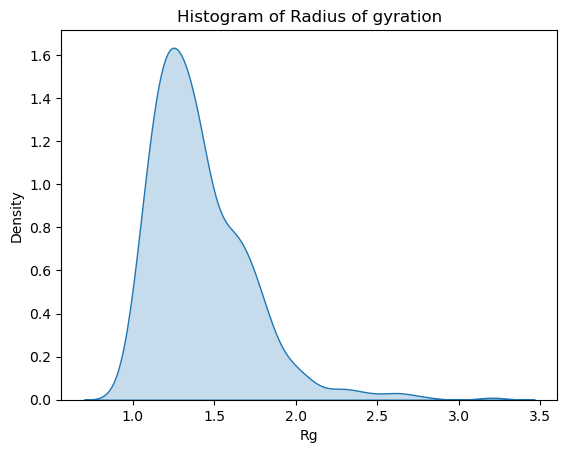

In [23]:
# Plotting the radius of gyration of the peptide in the trajectory

# gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600.trr -o 4-nvt-600-noPBC.trr -pbc mol -center

# gmx_mpi gyrate -s 4-nvt-600.gro -f 4-nvt-600-noPBC.trr -o 4-nvt-600-rgyr.xvg

data = pd.read_table("4-nvt-600-rgyr.xvg", delim_whitespace=True, skiprows=27, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")
x = data[0]
y = data[1]

sorted_y = sorted(y)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("Radius of Gyration (ns)")  # Add a y-label to the axes.
ax.set_title("Radius of Gyration of ab40")
plt.show()
plt.hist(sorted_y, bins=50, edgecolor='black', color='skyblue', alpha=0.7)

indices = np.where(y == 2.77667)
plt.show()

print(indices)
print(sorted_y[476])
import seaborn as sns
import matplotlib.pyplot as plt

# Create a KDE plot
sns.kdeplot(y, fill=True)

# Add title and labels
plt.title('Histogram of Radius of gyration')
plt.xlabel('Rg')
plt.ylabel('Density')

# Show the plot
plt.show()

# print(sorted_y)
# extract 476

In [ ]:
# extracting the frame with Rg 2.7 nm i.e. the second frame in the trajectory
gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600-noPBC.trr -o 4-nvt-600-noPBC-frame2.gro -dump 40 # 40 = 40 ps

# extracting the frame with Rg 1.96781 i.e. the 95-percentile
gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600-noPBC.trr -o 4-nvt-600-noPBC-95-percentile-Rg.gro -dump 600 # 40 = 40 ps

In [79]:
trajectory = "4-nvt-600-noPBC.trr"
topology = "4-nvt-600.gro"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))
# trj.center_coordinates()
top = trj2.topology
first_frame = 0
n_frames=trj.n_frames

frame = trj2[0]
frame.save('linear-test.gro')
# frame.save('4-nvt-600-95-percentile-rg.gro')

# frame = trj[0]
# frame.save('5-nvt-600-noPBC-no-water-mf-frame1.gro')
# trj.save_trr('5-nvt-600-no-water-mf.trr')

# trj2 = trj.slice(range(0, 2001, 10))
# print(trj2.n_frames)

# rg = md.compute_rg(trj2, masses=None)
# rg[131]

In [80]:
frame = trj2[1]
frame.save('linear-test.gro')

In [ ]:
# extracting collapsed structure from trajectory using mdtraj


topology=f"4-nvt-600.gro"
trajectory=f"4-nvt-600.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj = trj.atom_slice(range(598))
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

print(n_frames)

frame = trj[454]
frame.save('454.gro')
 
# ended up using the frame with the 95th Percentile Rgyr

### procedure for the 600 K run to extract confirmations for production run

In [ ]:


# 1. adding water molecules
gmx_mpi editconf -f template.gro -o template_newbox.gro -c -d 0.3 -bt dodecahedron
gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top

# Output configuration contains 34906 atoms in 11476 residues
# Volume                 :     353.625 (nm^3)
# Density                :     989.107 (g/l)
# Number of solvent molecules:  11436

# 2. adding ions
gmx_mpi grompp -f ../mdp_files/ions.mdp -c template_solv.gro -p ../topol.top -o genion_NaCl_input.tpr -maxwarn 2
# WARNING 2 [file topol.top, line 5632]:
#   96 non-matching atom names
#   atom names from ../topol.top will be used
#   atom names from template_solv.gro will be ignored
gmx_mpi genion -s genion_NaCl_input.tpr -o genion_NaCl_output.gro -conc 0.137 -pname NA -nname CL -p ../topol.top

gmx_mpi grompp -f ../mdp_files/ions.mdp -c genion_NaCl_output.gro -p ../topol.top -o genion_KCl_input.tpr -maxwarn 1
gmx_mpi genion -s genion_KCl_input.tpr -o genion_KCl_output.gro -conc 0.00268 -pname K -nname CL -p ../topol.top
# no KCl ions added

# 3. Energy minimization
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c  genion_KCl_output.gro -p ../topol.top -o em.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm em -v -maxh 11 &> em-terminal.log

# 4. position restraints
gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em.gro -r em.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr-terminal.log
gmx_mpi mdrun -deffnm 2-pr -rcon 1.5 -dds 0.8 -v &> 2-pr-terminal.log
# There is no domain decomposition for 60 ranks that is compatible with the
# given box and a minimum cell size of 1.37088 nm
# Change the number of ranks or mdrun option -rcon or -dds or your LINCS
# settings
# Look in the log file for details on the domain decomposition

# Changed the number of ranks to 42

# 5. Berendsen
gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

# 6. nvt-600
gmx_mpi grompp -f ../mdp_files/5-nvt-600.mdp -c 3-berendsen.gro -r 3-berendsen.gro -p ../topol.top -o 5-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 5-nvt-600 -v &> 5-nvt-600-terminal.log


In [ ]:
# centering the trajectory with gromacs
gmx_mpi trjconv -s 5-nvt-600.tpr -f 5-nvt-600.trr -o 5-nvt-600-noPBC.trr -pbc mol -center

In [ ]:
# checking contacts between the peptide and its periodic images to see if box size is large enough
gmx_mpi mindist -f 5-nvt-600.trr -s 5-nvt-600.tpr -pi -o 5-nvt-600-mindist.xvg

# The shortest periodic distance is 2.19476 (nm) at time 336 (ps),
# between atoms 94 and 549

3.376


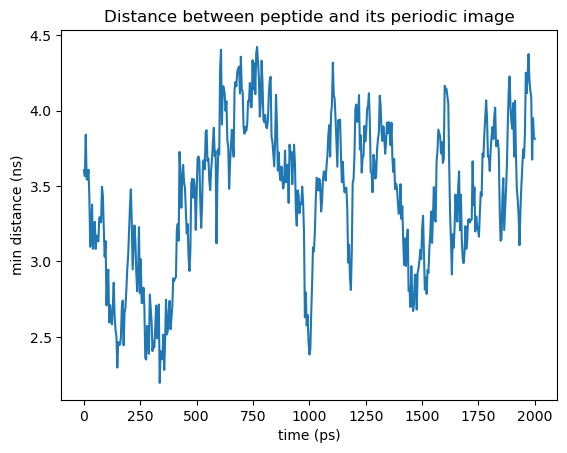

In [4]:

data = pd.read_table("../setup4/5-nvt-600-mindist.xvg", delim_whitespace=True, skiprows=29, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")
x = data[0]
y = data[1]

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("min distance (ns)")  # Add a y-label to the axes.
ax.set_title("Distance between peptide and its periodic image")

print(y[131])

#### Extracting different confirmations

In [7]:
topology=f"../setup4/5-nvt-600.gro"
trajectory=f"../setup4/5-nvt-600-noPBC.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))
# trj.center_coordinates()
top = trj2.topology
# n_frames=trj.n_frames
# n_frames

In [8]:
# # https://stackoverflow.com/questions/63321109/algorithm-for-selecting-a-subset-of-most-distant-elements
def find_largest_values(trj, N, M):
    candidates = []  # List to store pairs (j, l(j))
    S_prime = []  # Resulting subset

    # Calculate pairwise distances and initialize candidates list
    for i in range(N):
            rmsd = md.rmsd(trj, trj, i)
#             print(rmsd)
            rmsd = np.delete(rmsd, i)

            l_i = min(rmsd)
            candidates.append((i, l_i))

    # Sort candidates list by l(i) in descending order
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Select M elements with the largest values of l(i)
    for i in range(M):
        current_index, current_l_value = candidates[i]
        S_prime.append(current_index)

    return S_prime

indxs = find_largest_values(trj2, trj2.n_frames, 40)
indxs

[4,
 8,
 239,
 3,
 0,
 72,
 21,
 22,
 52,
 57,
 37,
 385,
 89,
 71,
 413,
 430,
 429,
 88,
 368,
 70,
 53,
 68,
 69,
 163,
 36,
 96,
 95,
 38,
 39,
 330,
 331,
 62,
 43,
 44,
 405,
 443,
 263,
 29,
 61,
 1]

In [18]:
for i in range(40):
    trj2[indxs[i]].save(f'../production/r{i}/only_protein.gro')

#### Checking that the dihedrals are okay for all replicas

In [20]:
# Ensuring that all residues are in the trans confirmation
topology=f"../setup4/5-nvt-600.gro"
trajectory=f"../setup4/5-nvt-600-noPBC.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))

omega = md.compute_omega(trj2)
# omega[0]


In [12]:
print(len(omega))
print(len(omega[0]))
print(len(omega[1]))
print(omega[1][500])

for replica_indx in indxs:
    for angles in omega[1]:
        for angle in angles:
            if -0.3 < angle < 0.3:
                print(f'error in replica: {replica_indx}')

2
39
501
[ 2.8618689  3.1341205  2.8353229  3.0855641  2.744904   3.0903986
 -2.7890184 -2.8603213  3.016471   2.9257429 -3.079303   2.930856
 -2.936725  -3.1035347 -3.1221862  3.0916374  3.0388474  2.9053464
  2.9350076 -2.9589572  2.5622003 -3.1280773 -2.9739025 -2.9278398
 -3.0506823 -2.8122613  3.1412342  3.06947    3.1180558 -3.066726
  2.9569838  3.0712438  2.922096  -3.0873876 -2.838086   3.0666306
  2.761867   3.1335268 -3.0379405]


In [25]:
# Checking Ramachandran plot of the peptide
indxs[0]

4

plotting Ramachandran plot of Replica 0


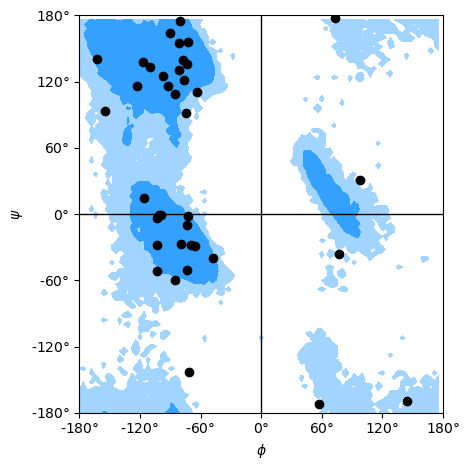

plotting Ramachandran plot of Replica 1


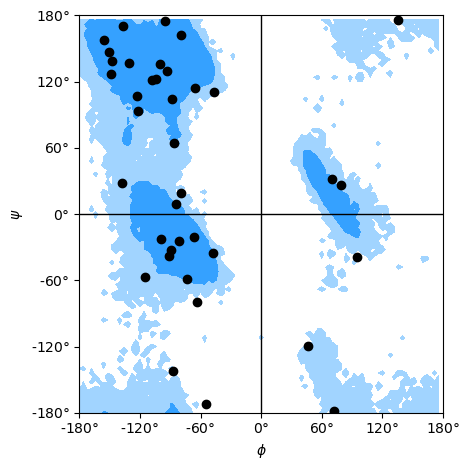

plotting Ramachandran plot of Replica 2


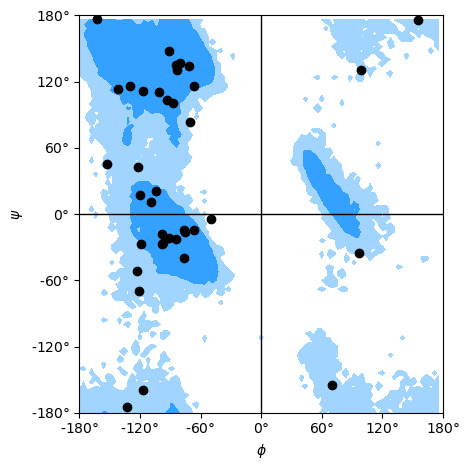

plotting Ramachandran plot of Replica 3


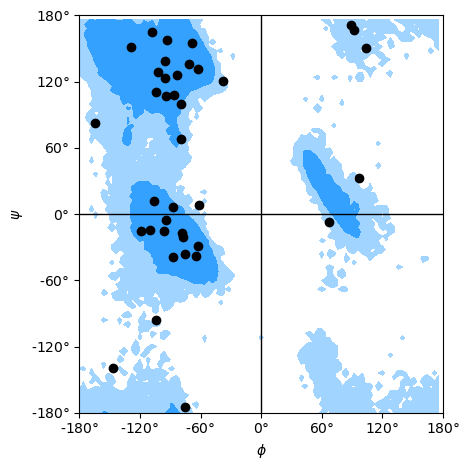

plotting Ramachandran plot of Replica 4


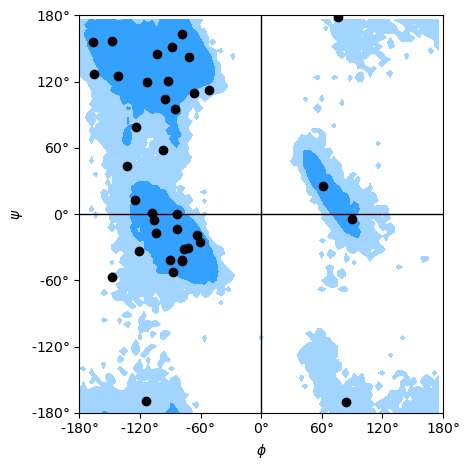

plotting Ramachandran plot of Replica 5


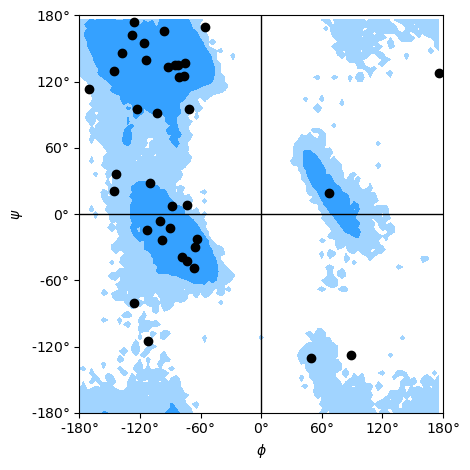

plotting Ramachandran plot of Replica 6


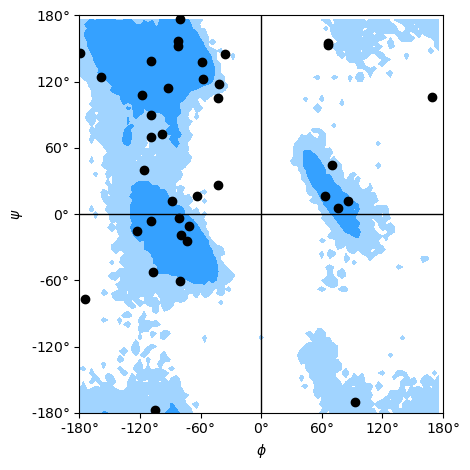

plotting Ramachandran plot of Replica 7


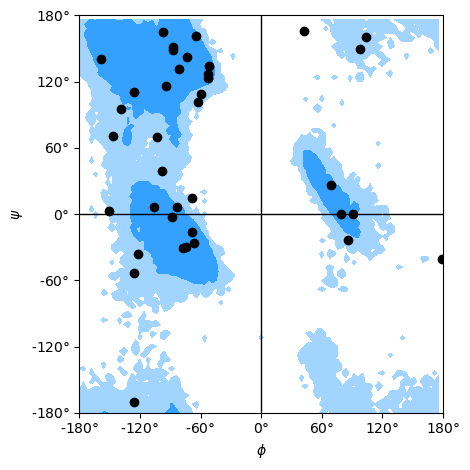

plotting Ramachandran plot of Replica 8


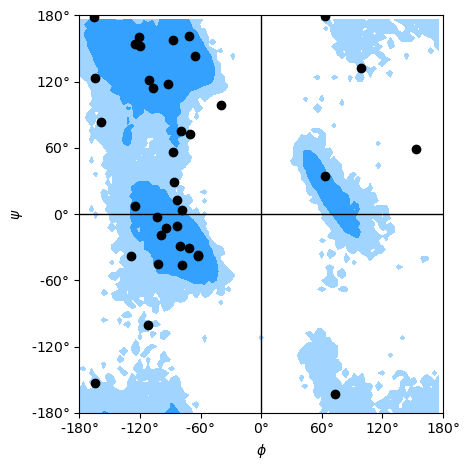

plotting Ramachandran plot of Replica 9


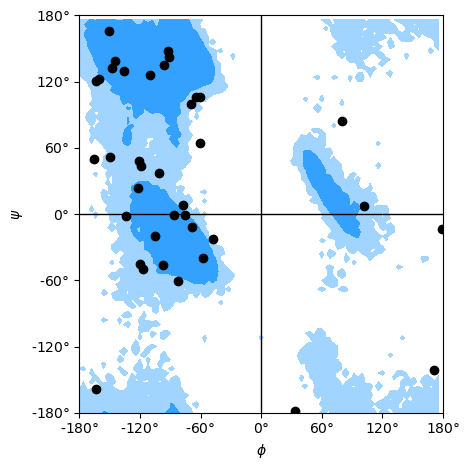

plotting Ramachandran plot of Replica 10


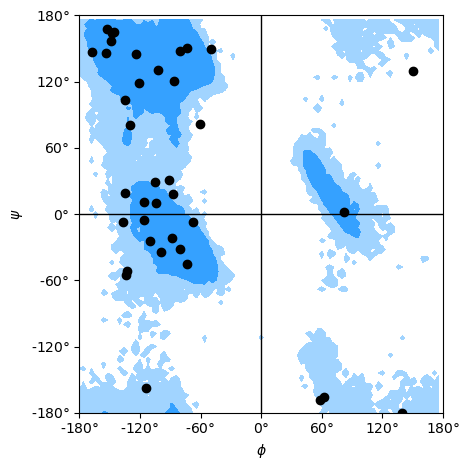

plotting Ramachandran plot of Replica 11


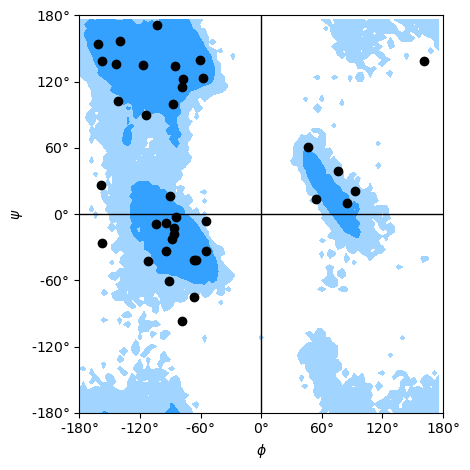

plotting Ramachandran plot of Replica 12


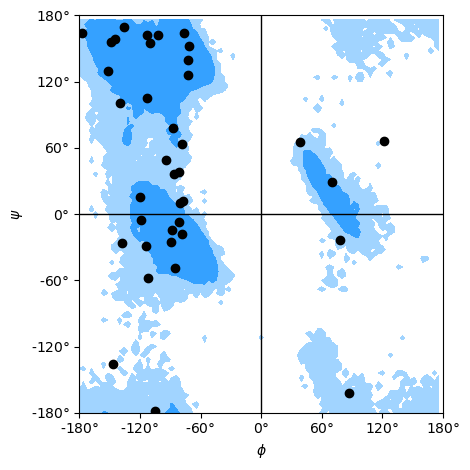

plotting Ramachandran plot of Replica 13


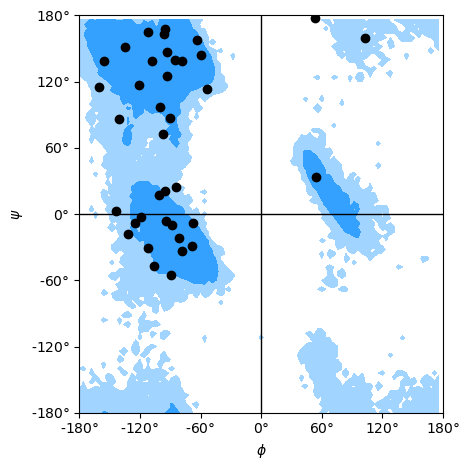

plotting Ramachandran plot of Replica 14


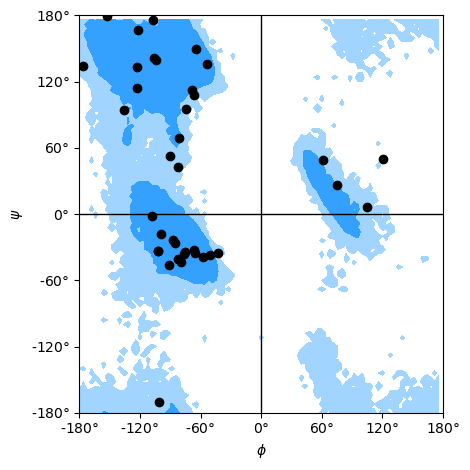

plotting Ramachandran plot of Replica 15


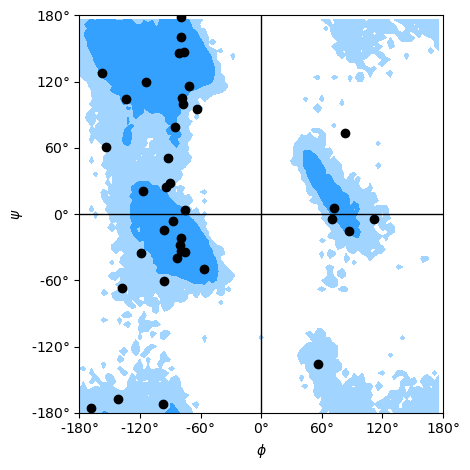

plotting Ramachandran plot of Replica 16


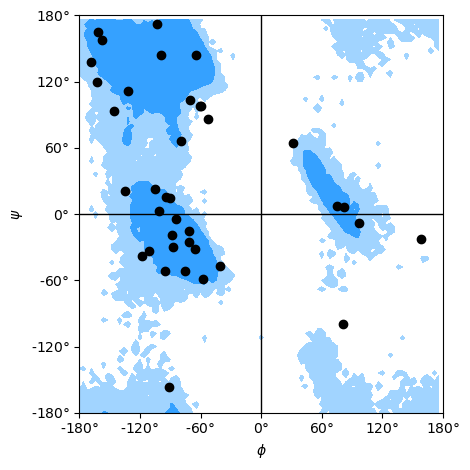

plotting Ramachandran plot of Replica 17


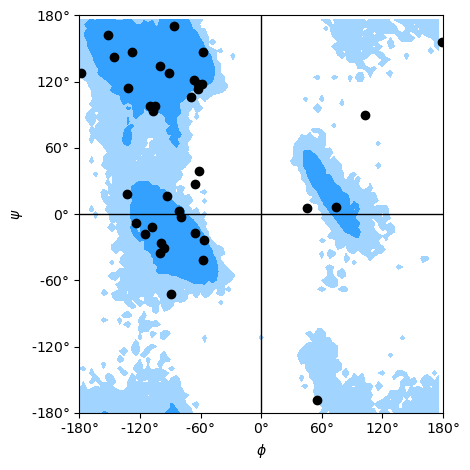

plotting Ramachandran plot of Replica 18


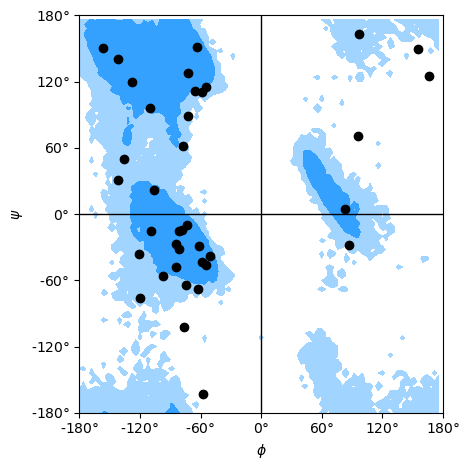

plotting Ramachandran plot of Replica 19


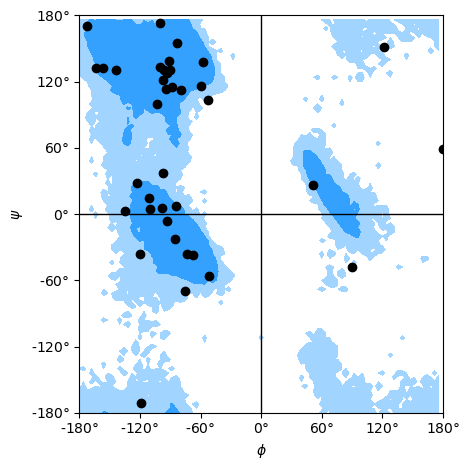

plotting Ramachandran plot of Replica 20


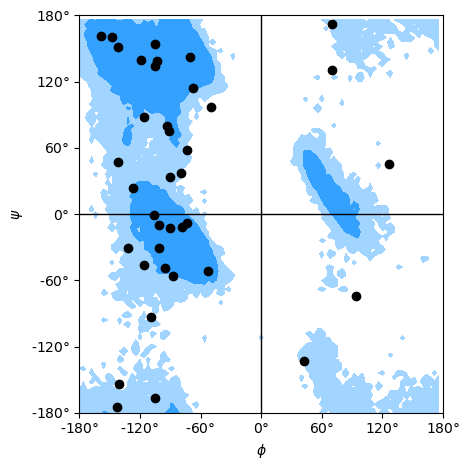

plotting Ramachandran plot of Replica 21


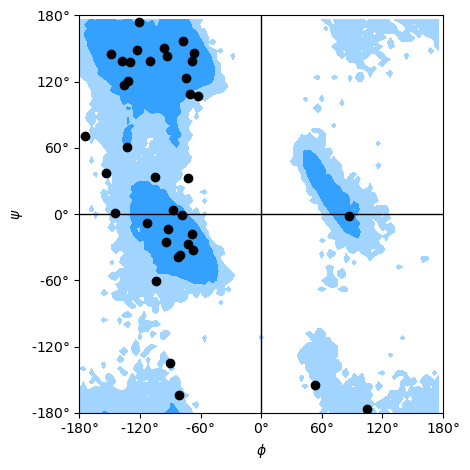

plotting Ramachandran plot of Replica 22


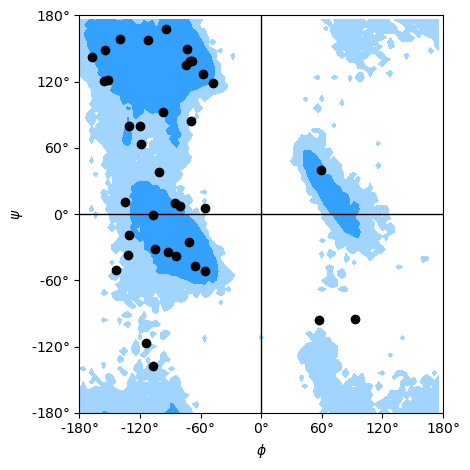

plotting Ramachandran plot of Replica 23


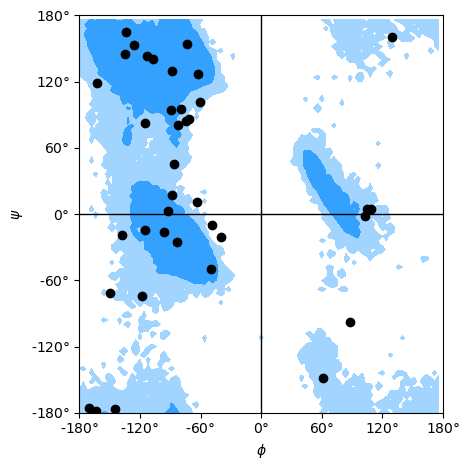

plotting Ramachandran plot of Replica 24


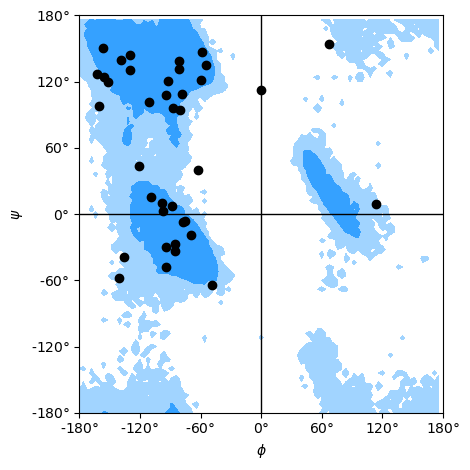

plotting Ramachandran plot of Replica 25


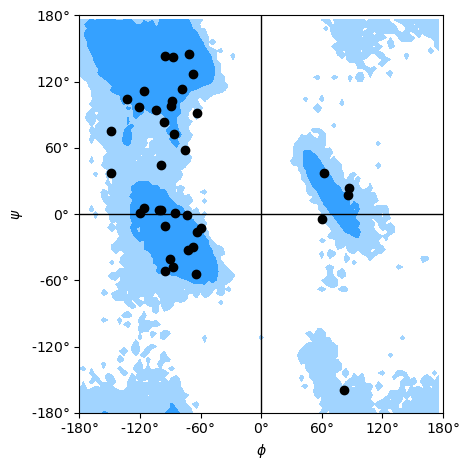

plotting Ramachandran plot of Replica 26


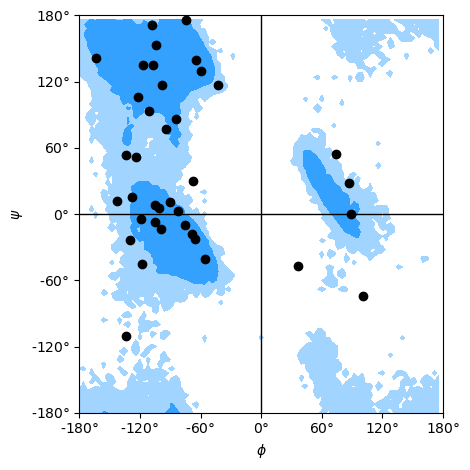

plotting Ramachandran plot of Replica 27


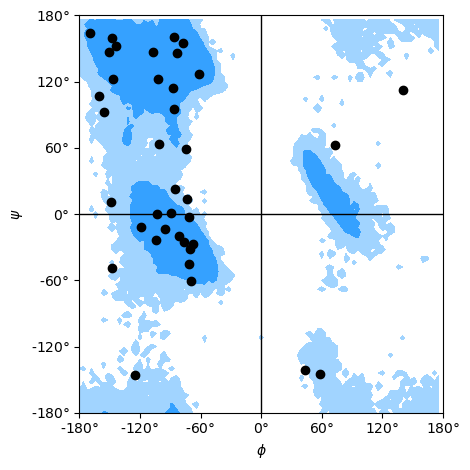

plotting Ramachandran plot of Replica 28


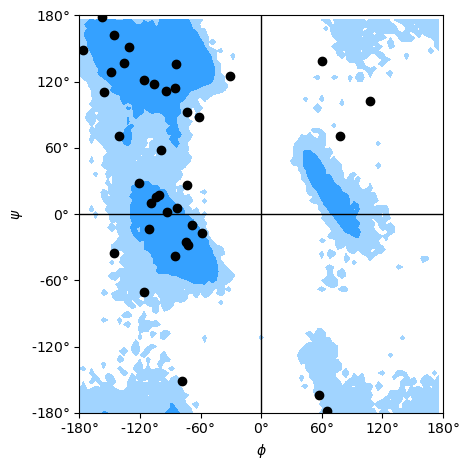

plotting Ramachandran plot of Replica 29


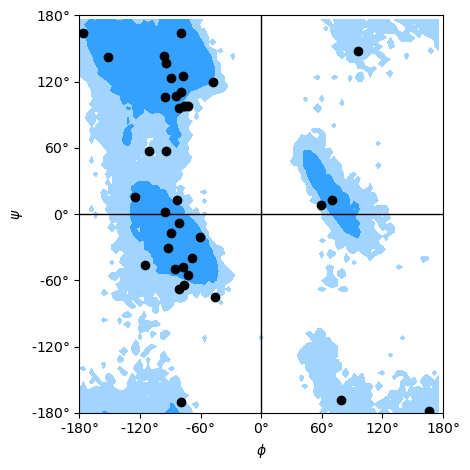

plotting Ramachandran plot of Replica 30


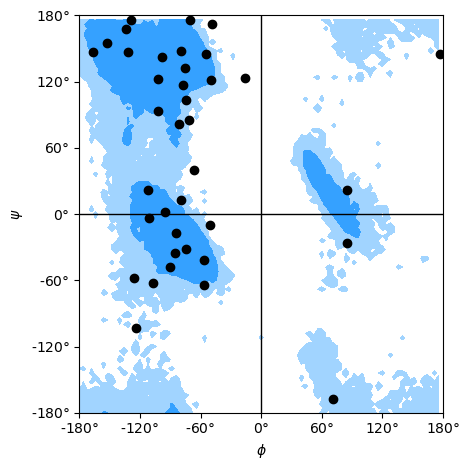

plotting Ramachandran plot of Replica 31


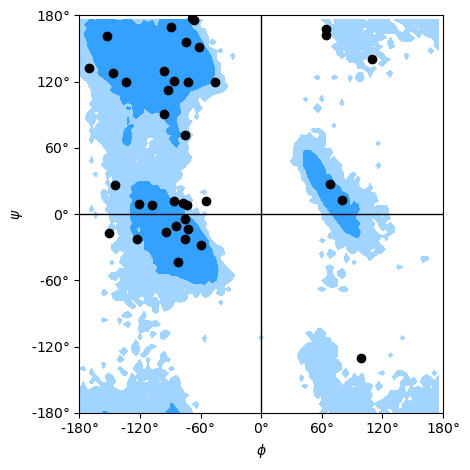

plotting Ramachandran plot of Replica 32


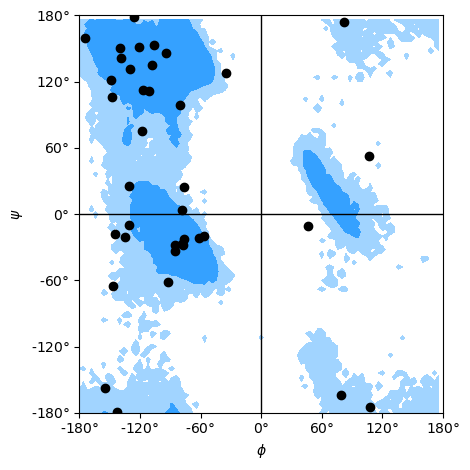

plotting Ramachandran plot of Replica 33


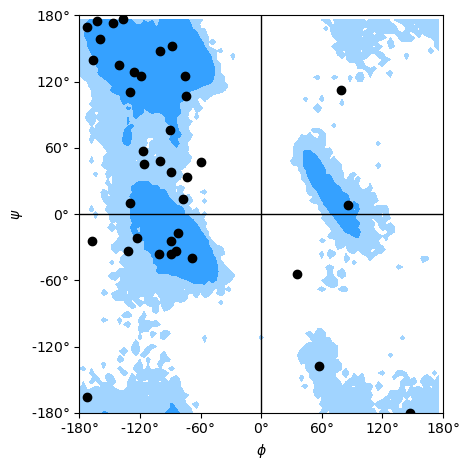

plotting Ramachandran plot of Replica 34


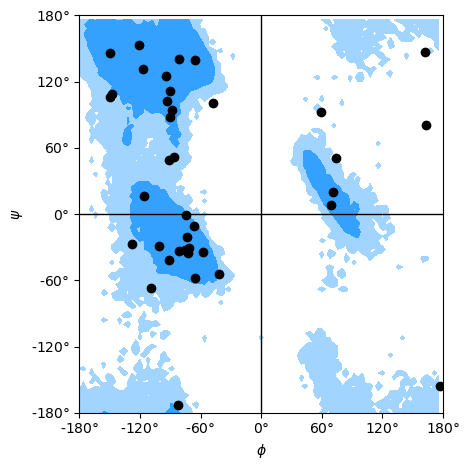

plotting Ramachandran plot of Replica 35


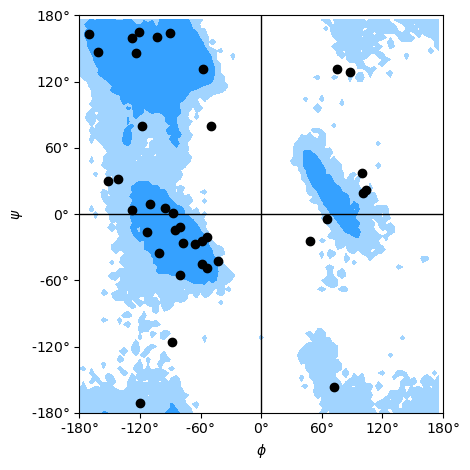

plotting Ramachandran plot of Replica 36


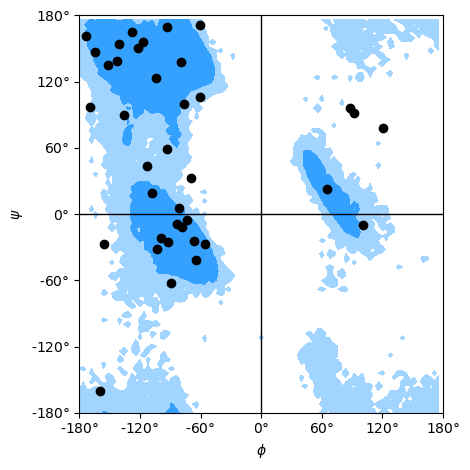

plotting Ramachandran plot of Replica 37


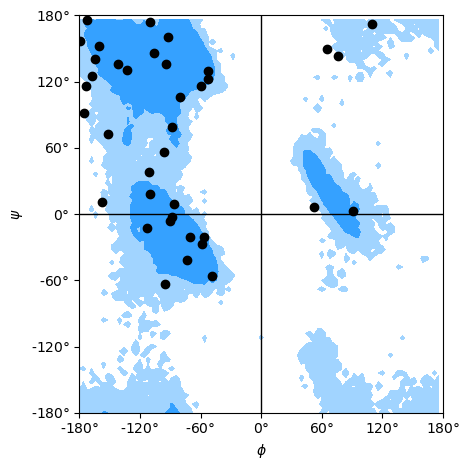

plotting Ramachandran plot of Replica 38


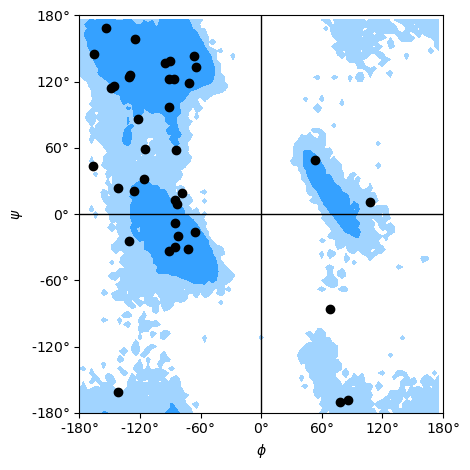

plotting Ramachandran plot of Replica 39


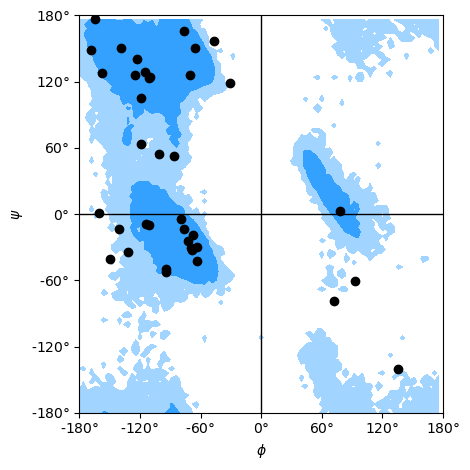

In [36]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis.dihedrals import Dihedral


# phis = md.compute_phi(trj2)[1][indxs[0]]
# psis = md.compute_psi(trj2)[1][indxs[0]]

# print(np.rad2deg(psis))

# print("Ramachandran plot of replica 0")
# plt.figure(figsize=(8, 6))
# plt.scatter(phis * 180/3.14, psis * 180/3.14, s=10, color='blue', alpha=0.5)
# plt.xlim(-180, 180)
# plt.ylim(-180, 180)
# plt.xlabel('Phi (ϕ) angles')
# plt.ylabel('Psi (ψ) angles')
# plt.title('Ramachandran Plot')
# plt.grid(True)
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)
# plt.show()

# u = mda.Universe(f'../production/r0/only_protein.gro')
# r = u.select_atoms("resid 1-40")


# phi_selection = [(res.phi_selection()) for res in r.residues]
# psi_selection = [(res.psi_selection()) for res in r.residues]
# dihedral_selection = [d for d in psi_selection if d]

# Calculate the dihedrals
# dihedrals = Dihedral(dihedral_selection).run()

# print(dihedrals.angles)


for i in range(40):
    # Load the protein structure from a .gro file
    print(f"plotting Ramachandran plot of Replica {i}")
    u = mda.Universe(f'../production/r{i}/only_protein.gro')
    r = u.select_atoms("resid 1-40")

    R = Ramachandran(r).run()

    fig, ax = plt.subplots(figsize=plt.figaspect(1))
    R.plot(ax=ax, color='k', marker='o', ref=True)
    fig.tight_layout()
    plt.show()





In [ ]:
# after extracting 40 confirmations, setup the system for production run

# Carrying out NVT for 500 ps for each replica

# 1. NVT
gmx_mpi grompp -f ../mdp_files/6-nvt-278.mdp -c r0/replica.gro -p ../topol.top -o r0/nvt.tpr
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/5-nvt-run.mdp -c r0/em.gro -p ../topol.top -o r${i}/nvt.tpr; done

# 3. NPT

In [2]:
# nres=[]



# for res in trj.topology.residues: nres.append(res.resSeq)
# sequence=(' %s' % [residue for residue in trj.topology.residues])
# resname=(' %s' % [residue.name for residue in trj.topology.residues])
# resindex=(' %s' % [residue.index for residue in trj.topology.residues])
# res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



# #log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
# # print("** SYSTEM INFO **\n")
# # print("Number of atoms: %d\n" % trj.n_atoms)
# # print("Number of residues: %d\n" % len(set(nres)))
# # print("Number of frames: %d\n" % trj.n_frames)
# # print("Starting frame: %d\n" % first_frame)
# # print("Last frame: %d\n" % last_frame)
# # print("sequence: %s\n" % sequence)
# # print("residue names: %s\n" % resname)
# # print("residue number: %s\n" % res_num)
# # print("residue index: %s\n" % resindex)
# resname = [residue.name for residue in trj.topology.residues]
# resname
# # DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
# # DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV
# # print(''.join(resname))

In [3]:
# rmsd = md.rmsd(trj2, trj2, 0)
# # print(max(rmsd))
# rmsd = md.rmsd(trj2, trj2, 0)

# # Find the index of the maximum value
# max_index = np.argmax(rmsd)
# max_index